## LDA Approximation in the ZZ XZ case

#### Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.optimize import curve_fit

# def pade(z:np.ndarray,a_p,b_p,c_p,d_p,e_p,a_q,b_q,c_q,d_q):
#     z_poly=z[None,:]**((4-np.arange(5)))[:,None]
#     f=(z_poly[0,:]*a_p+z_poly[1,:]*b_p+z_poly[2,:]*c_p+z_poly[3,:]*d_p+z_poly[-1,:]*e_p)/(z_poly[0,:]*a_q+z_poly[1,:]*b_q+z_poly[2,:]*c_q+z_poly[3,:]*d_q)
#     return f

def pade(m:np.ndarray,*params):
    z=m[:,0]
    x=m[:,1]    
    
    z_poly=(z[None,:])**((np.arange(0,5,1)))[:,None]
    x_poly=(x[None,:])**((np.arange(0,5,1)))[:,None]
    up=np.zeros(m.shape[0])
    for i in range(5):
        for j in range(5):
            up=up+params[5*i+j]*z_poly[i,:]*x_poly[j,:]
    down=np.ones(m.shape[0])
    for i in range(4):
        for j in range(4):
            down=down+params[25+4*i+j]*z_poly[i,:]*x_poly[j,:]
            
    
    f=up/down
    return f

def lda_functional(m:np.ndarray,params):
    f_lda=np.zeros_like(m[:,0,:])
    for a in range(m.shape[-1]):
        z=m[:,0,a]
        x=m[:,1,a]    
        
        z_poly=(z[None,:])**((np.arange(0,5,1)))[:,None]
        x_poly=(x[None,:])**((np.arange(0,5,1)))[:,None]
        up=np.zeros(m.shape[0])
        for i in range(5):
            for j in range(5):
                up=up+params[5*i+j]*z_poly[i,:]*x_poly[j,:]
        down=np.ones(m.shape[0])
        for i in range(4):
            for j in range(4):
                down=down+params[25+4*i+j]*z_poly[i,:]*x_poly[j,:]
        f_lda[:,a]=up/down
    return f_lda

#### Data

0.5050505050505051 0.5050505050505051



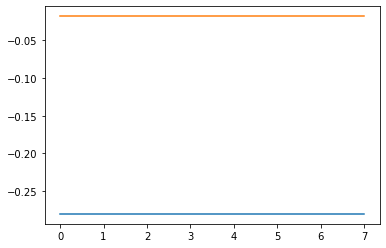

In [5]:

data=np.load('data/kohm_sham_approach/uniform/dataset_lda_h_0_5_omega_0_5_j_1_1nn_linear_span_100.npz')

z=data['density']
x=data['transverse_magnetization']

z_torch=torch.from_numpy(z)
x_torch=torch.from_numpy(x)
m_torch=torch.cat((z_torch.unsqueeze(1),x_torch.unsqueeze(1)),dim=1)

f_dens=data['density_F']
omega_value=data['omega_value']
h_value=data['h_value']
f=np.average(f_dens,axis=-1)
# # plt.hist(np.average(x,axis=-1),bins=100)
# # plt.show()
# # plt.hist(np.average(z,axis=-1),bins=100)
# # plt.show()
# # plt.hist(f,bins=100)
# # plt.show()
idx=10
jdx=10
print(omega_value[idx],h_value[jdx])

plt.plot(x[idx*100+jdx])
plt.plot(z[idx*100+jdx])
print()
plt.show()


(10000,)
(10000, 8)


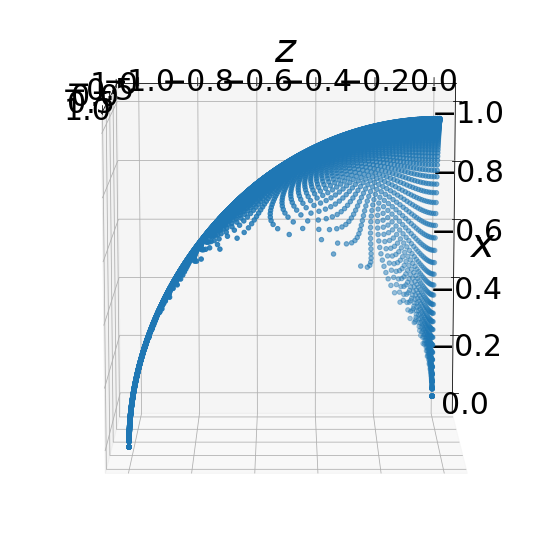

In [6]:
print(f.shape)
print(z.shape)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(10,10))
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),f,marker='o')
plt.ylabel(r'$z$',fontsize=40)
plt.xlabel(r'$x$',fontsize=40)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=2,
        )
ax.view_init(elev=100, azim=0)
plt.show()

#### Fit the LDA in case of costant fields

In [7]:
from src.tddft_methods.model_lda import modelLDA
import torch

m=np.append(z.reshape(-1,1,8),x.reshape(-1,1,8),axis=1)


params,_=curve_fit(f=pade,xdata=np.average(m,axis=-1),ydata=f,p0=0.5*np.ones(25+16))


#model=modelLDA(torch.tensor(coeff))
f_ml=lda_functional(m=m,params=params)
print(f_ml.shape)

(10000, 8)


(100, 100)
(10000, 8)


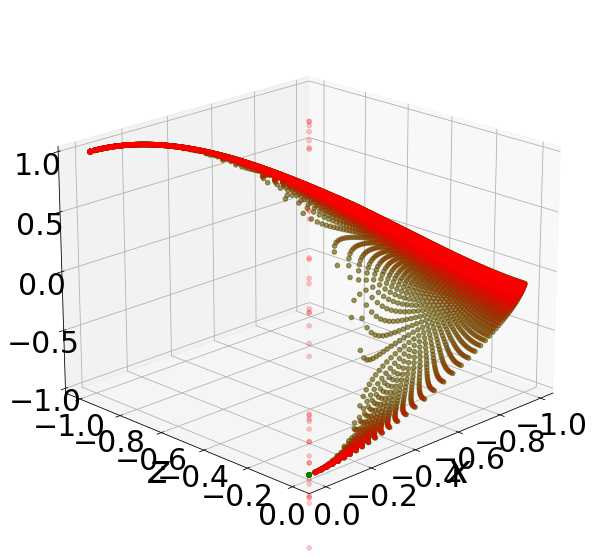

In [9]:
f_value_ml=np.average(f_ml,axis=-1).reshape(100,100)
f=f.reshape(100,100)
print(f.shape)
print(z.shape)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(10,10))
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),f,marker='o',color='green',alpha=0.5)
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),f_value_ml,marker='o',color='red',alpha=0.2)
plt.ylabel(r'$z$',fontsize=40)
plt.xlabel(r'$x$',fontsize=40)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=2,
        )
ax.view_init(elev=20, azim=45)
ax.set_zlim([-1,1])
plt.show()


Save the LDA functional as pytorch model

In [10]:
model=modelLDA(coeff=params)

torch.save(model,'model_rep/lda/lda_model')

### Comparison LDA vs other models

In [11]:
model=torch.load('model_rep/kohm_sham/disorder/model_zzxz_2_input_channel_dataset_h_mixed_0.0_5.0_h_0.0-2.0_j_1_1nn_n_500k_unet_l_train_8_[40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_6_nconv_0_nblock', map_location='cpu')
model.eval()

f_dl=model(m_torch).detach().numpy()

f_value_dl=np.average(f_dl,axis=-1).reshape(100,100)



(100, 100)
(10000, 8)


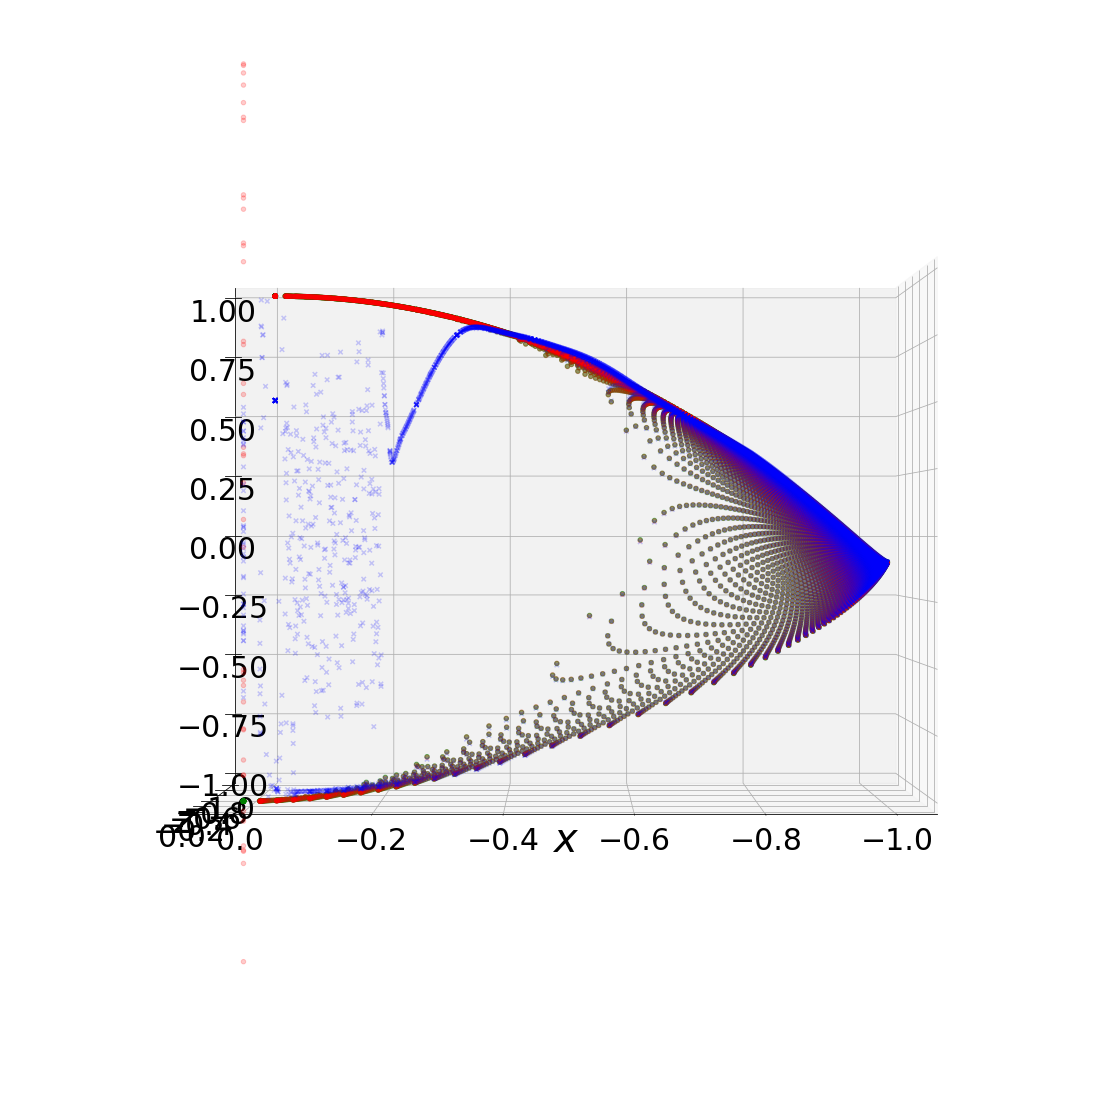

In [30]:
f_value_ml=np.average(f_ml,axis=-1).reshape(100,100)
f=f.reshape(100,100)
print(f.shape)
print(z.shape)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(20,20))
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),f,marker='o',color='green',alpha=0.5)
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),f_value_ml,marker='o',color='red',alpha=0.2)
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),f_value_dl,marker='x',color='blue',alpha=0.2)
plt.ylabel(r'$z$',fontsize=40)
plt.xlabel(r'$x$',fontsize=40)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=2,
        )
ax.view_init(elev=0, azim=90)
ax.set_zlim([-1,1])
plt.show()


Mapping of the errors

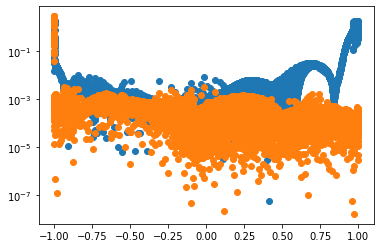

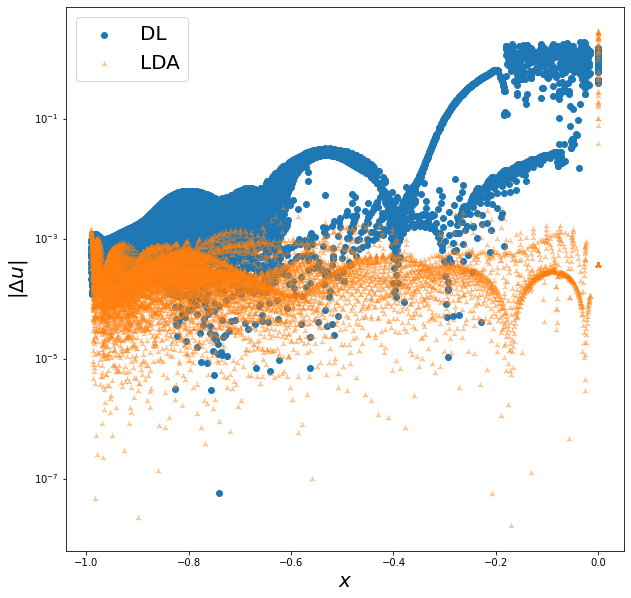

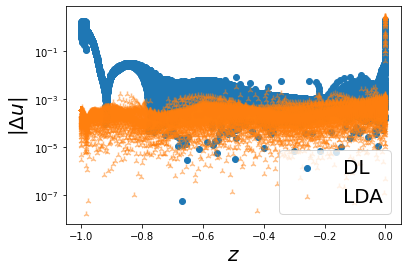

In [35]:
df_dl=np.abs(f.reshape(-1)-f_value_dl.reshape(-1))
df_lda=np.abs(f.reshape(-1)-f_value_ml.reshape(-1))

plt.scatter(f.reshape(-1),df_dl)
plt.scatter(f.reshape(-1),df_lda)
plt.semilogy()
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(np.average(x,axis=-1),df_dl,label=r'DL')
plt.scatter(np.average(x,axis=-1),df_lda,marker='2',alpha=0.5,label='LDA')
plt.xlabel(r'$x$',fontsize=20)
plt.ylabel(r'$|\Delta u|$',fontsize=20)
plt.legend(fontsize=20)
plt.semilogy()
plt.show()


plt.scatter(np.average(z,axis=-1),df_dl,label=r'DL')
plt.scatter(np.average(z,axis=-1),df_lda,marker='2',alpha=0.5,label=r'LDA')
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$|\Delta u|$',fontsize=20)
plt.legend(fontsize=20)

plt.semilogy()
plt.show()


### How much the disorder dataset diverges from the uniform dataset